In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
import IPython
import IPython.display
from pathlib import Path
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

comp_dir = Path('../input/store-sales-time-series-forecasting')

In [3]:
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'], #, 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
       # 'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

In [4]:
print('store_sales: \n', store_sales.shape)
display(store_sales.head())
mean_by_family_all_years = store_sales.groupby(['family', 'date']).mean()
mean_by_family_all_years = mean_by_family_all_years.unstack('family')['sales']
print(mean_by_family_all_years.shape)
mean_by_family_all_years.head()

store_sales: 
 (3000888, 1)


sales
store_nbr family     date             
1         AUTOMOTIVE 2013-01-01    0.0
                     2013-01-02    2.0
                     2013-01-03    3.0
                     2013-01-04    3.0
                     2013-01-05    5.0

(1684, 33)


family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.000000,0.0,0.037037,15.000000,0.0,3.344241,0.0,3.444444,2.648148,1.316481,...,0.0,2.051870,0.462963,0.0,0.0,0.789574,0.700870,0.0,0.0,0.000000
2013-01-02,4.722222,0.0,3.833333,1335.036987,0.0,486.042938,0.0,1382.018555,432.981476,291.750000,...,0.0,386.508606,318.592590,0.0,0.0,258.812683,98.853928,0.0,0.0,28.273148
2013-01-03,2.981482,0.0,2.314815,964.907410,0.0,341.786682,0.0,1035.055542,333.351837,206.897308,...,0.0,307.359222,232.740738,0.0,0.0,197.673965,66.507187,0.0,0.0,20.265018
2013-01-04,3.129630,0.0,2.462963,1003.092590,0.0,309.666077,0.0,964.148132,336.074066,187.837204,...,0.0,400.480804,209.314819,0.0,0.0,199.491013,82.832703,0.0,0.0,23.946686
2013-01-05,6.333333,0.0,3.537037,1441.074097,0.0,414.217804,0.0,1298.666626,427.444458,254.350830,...,0.0,386.649841,311.462952,0.0,0.0,249.537201,107.964317,0.0,0.0,23.067352


## Time features

In [5]:
df_target_mean_2017 =  mean_by_family_all_years.loc['2017']

fourier = CalendarFourier(freq="M", order=4) 
dp = DeterministicProcess(
    index=df_target_mean_2017.index,
    constant=True,
    order=1,
    # YOUR CODE HERE
    seasonal=True, 
    additional_terms=[fourier],
    drop=True,
)
x_base =  dp.in_sample()
x_base['new_year'] = (x_base.index.dayofyear == 1)*1.0
x_base.shape

(227, 17)

## Models

In [6]:
# machine learning model
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

from sklearn.model_selection import TimeSeriesSplit

#hyper parameter search
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_histogram, plot_objective_2D
from skopt.utils import use_named_args
import gc




In [7]:
#Define the space of search for each hyperparameter
dim_learning_rate = Real(low=1e-4, high=0.1, prior='log-uniform', name='learning_rate')
dim_max_depth = Categorical(categories=[5, 9, 10, 14], name='max_depth') #Real(low=0.1, high=0.9, name='rho_value')
dim_min_child_weight = Categorical(categories=[1, 5, 6, 10], name='min_child_weight')

dim_subsample = Real(low=0.1, high=1.0, name='subsample') 
dim_colsample_bytree = Real(low=0.1, high=1.0, name='colsample_bytree') 
dim_reg_alpha = Real(low=0.1, high=0.8, name='reg_alpha')
dim_n_estimators = Categorical(categories=[30, 50, 70, 100, 150], name='n_estimators')

dimensions = [dim_learning_rate, dim_max_depth, dim_min_child_weight, dim_subsample, dim_colsample_bytree,
             dim_reg_alpha, dim_n_estimators]

def train_model(param_tmp, x_train, y_train, x_val, y_val):
    model = XGBRegressor(learning_rate = param_tmp['learning_rate'], 
                         max_depth = param_tmp['max_depth'],
                         min_child_weight = param_tmp['min_child_weight'],
                         subsample = param_tmp['subsample'],
                         colsample_bytree = param_tmp['colsample_bytree'],
                         reg_alpha = param_tmp['reg_alpha'],
                         n_estimators = param_tmp['n_estimators']) 
    
    model.fit(x_train, y_train)

    y_pred_train = model.predict(x_train)  
    y_pred_val = model.predict(x_val)               

    df_rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train, multioutput='raw_values'))
    df_rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val, multioutput='raw_values'))   
    
    return model, df_rmse_train, df_rmse_val

iteration = 0
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, max_depth, min_child_weight, subsample, colsample_bytree, reg_alpha, n_estimators):   
    global iteration   
    global list_metrics_results
    
    def fitness_function(param_tmp):                              
        num_partition = 0         
        list_rmse_val = []        
        tscv = TimeSeriesSplit(n_splits=3, max_train_size=None, test_size=15, gap=0)    
        for index_train, index_val in tscv.split(np.arange(x_train.shape[0])): 
            
            print('------------------')               
            print('__ partition:', num_partition,'__')
            print('index_train:', index_train[0], 'to', index_train[-1])
            print('index_val:',  index_val[0], 'to', index_val[-1])            
            print('split train, val :', index_train.shape, index_val.shape)
            print('------------------')   
                    
            model, df_rmse_train, df_rmse_val = train_model(param_tmp, 
                                                            x_train.iloc[index_train, :], y_train.iloc[index_train, :], 
                                                            x_train.iloc[index_val, :], y_train.iloc[index_val, :])                        
            print('rmse train:', df_rmse_train.mean(),'\n', 
                  'rmse val:', df_rmse_val.mean(), '\n')
                                           
            list_rmse_val.append(df_rmse_val.mean())                                 
            num_partition += 1 
            
        IPython.display.clear_output()
        
        weights = np.array([0.6, 0.3, 0.1])        
        mean_rmse = np.round(np.mean(list_rmse_val), 2)
        weight_mean_rmse = np.round(np.mean(np.array(list_rmse_val)*weights), 2)
        
        print("*** ---- Hyperparameters ---- ***")
        print(param_tmp)
        print('metrics:')
        print('mean_rmse:', mean_rmse, 'weight_mean_rmse:', weight_mean_rmse)                                   
        list_metrics_results.append({'mean_rmse':np.round(np.mean(list_rmse_val), 2), 
                                     'weight_mean_rmse':weight_mean_rmse,
                                     'cv_rmse_val':list_rmse_val}) 
        return weight_mean_rmse #mean_rmse

    print("____________Iteration:", iteration, "___________")
    
    param_tmp = {'learning_rate':learning_rate, 
              'max_depth': max_depth,  
              'min_child_weight':min_child_weight, 
              'subsample': subsample, 
              'colsample_bytree': colsample_bytree, 
              'reg_alpha': reg_alpha,
              'n_estimators': n_estimators} 
        
    accuracy = fitness_function(param_tmp)    

    iteration += 1 
    gc.collect()

    return accuracy

In [8]:
## split data
size_test = 15
x_train = x_base.iloc[:-size_test] 
y_train = df_target_mean_2017.iloc[:-size_test] 

x_test = x_base.iloc[-size_test:]
y_test = df_target_mean_2017.iloc[-size_test:]
    
print("all data:", x_base.shape, "\ntrain:", x_train.shape, y_train.shape, 
      "\ntest:", x_test.shape, y_test.shape)

all data: (227, 17) 
train: (212, 17) (212, 33) 
test: (15, 17) (15, 33)


In [9]:
iteration = 0
list_metrics_results = []
default_parameters = [0.1, 9, 6, 0.8, 0.8, 0.1, 50]
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=30,
                            x0=default_parameters)

*** ---- Hyperparameters ---- ***
{'learning_rate': 0.0369596950323374, 'max_depth': 14, 'min_child_weight': 10, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.1, 'n_estimators': 30}
metrics:
mean_rmse: 168.34 weight_mean_rmse: 55.86


<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

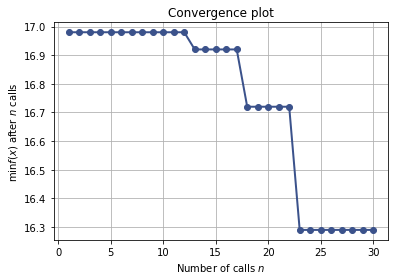

In [10]:
plot_convergence(search_result)

In [12]:
gp_results = pd.DataFrame(np.hstack([search_result.func_vals.reshape(-1,1), np.array(search_result.x_iters)])).sort_values(0)
gp_results.columns = ['metric', 'learning_rate', 'max_depth', 'min_child_weight', 'subsample', 
                      'colsample_bytree', 'reg_alpha', 'n_estimators']
gp_results['metric'] = gp_results['metric'].astype(np.float32)
gp_results = pd.concat([gp_results, pd.DataFrame(list_metrics_results)], axis=1)
gp_results = gp_results.sort_values('metric')
gp_results

,metric,learning_rate,max_depth,min_child_weight,subsample,colsample_bytree,reg_alpha,n_estimators,mean_rmse,weight_mean_rmse,cv_rmse_val
22,16.290001,0.043005,14.0,10.0,1.000000,0.929520,0.100000,150.0,47.580002,16.29,"[49.510456, 49.193806, 44.045895]"
17,16.719999,0.047660,10.0,10.0,1.000000,0.675666,0.800000,150.0,50.400002,16.72,"[49.433388, 51.605694, 50.151886]"
12,16.920000,0.032995,5.0,6.0,1.000000,1.000000,0.800000,150.0,51.119999,16.92,"[48.370888, 56.13982, 48.838856]"
0,16.980000,0.100000,9.0,6.0,0.800000,0.800000,0.100000,50.0,51.490002,16.98,"[48.84287, 55.293365, 50.3228]"
27,17.010000,0.049739,5.0,10.0,1.000000,1.000000,0.800000,150.0,50.230000,17.01,"[50.785538, 52.874733, 47.024208]"
20,17.219999,0.071049,14.0,10.0,0.849097,1.000000,0.800000,150.0,50.220001,17.22,"[52.590202, 51.42998, 46.629158]"
24,17.559999,0.068108,5.0,6.0,1.000000,0.860763,0.100000,150.0,50.939999,17.56,"[54.22209, 51.431416, 47.153934]"
14,17.610001,0.100000,5.0,10.0,1.000000,1.000000,0.800000,150.0,50.610001,17.61,"[54.613777, 51.740765, 45.474983]"
11,17.670000,0.100000,5.0,10.0,1.000000,1.000000,0.800000,30.0,54.299999,17.67,"[47.687042, 64.32472, 50.88725]"
25,18.200001,0.030295,14.0,10.0,1.000000,0.790531,0.800000,100.0,54.700001,18.20,"[51.117462, 63.207645, 49.766888]"


In [13]:
## Final evaluation over the test using the top-10 hp
def final_evaluation(n, gp_results):
    list_results = []        
    for i in range(n):        
        best_hp = gp_results.iloc[i, 1:8].to_dict()
        
        best_hp['max_depth'] = int(best_hp['max_depth'])
        best_hp['n_estimators'] = int(best_hp['n_estimators'])
        print('top:',i, 'param:', best_hp)
        model, df_rmse_train, df_rmse_test = train_model(best_hp, x_train, y_train, x_test, y_test)
        print('rmse train:', df_rmse_train.mean(),' rmse test:', df_rmse_test.mean(),'\n')        
        list_results.append({'rmse train':df_rmse_train.mean(), 'rmse test':df_rmse_test.mean()})
    return list_results

In [16]:
list_results = final_evaluation(30, gp_results)

top: 0 param: {'learning_rate': 0.04300454784710047, 'max_depth': 14, 'min_child_weight': 10.0, 'subsample': 1.0, 'colsample_bytree': 0.9295203065568836, 'reg_alpha': 0.1, 'n_estimators': 150}
rmse train: 41.281487  rmse test: 58.066936 

top: 1 param: {'learning_rate': 0.04766022814822882, 'max_depth': 10, 'min_child_weight': 10.0, 'subsample': 1.0, 'colsample_bytree': 0.6756657952731185, 'reg_alpha': 0.8, 'n_estimators': 150}
rmse train: 41.390533  rmse test: 59.839447 

top: 2 param: {'learning_rate': 0.032994864059755755, 'max_depth': 5, 'min_child_weight': 6.0, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.8, 'n_estimators': 150}
rmse train: 48.24993  rmse test: 53.35472 

top: 3 param: {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}
rmse train: 43.03627  rmse test: 56.682602 

top: 4 param: {'learning_rate': 0.04973940115489217, 'max_depth': 5, 'min_child_weight': 10.0, 's

In [17]:
## higher 10
pd.DataFrame(list_results[0:10])

,rmse train,rmse test
0,41.281487,58.066936
1,41.390533,59.839447
2,48.249931,53.354721
3,43.036270,56.682602
4,46.656223,56.777222
5,34.568787,58.448570
6,37.085552,57.293133
7,36.453938,58.643764
8,65.168617,48.883930
9,63.522499,48.090019


In [19]:
## lower 10
pd.DataFrame(list_results[-10:])

,rmse train,rmse test
0,111.532440,74.577377
1,130.756775,98.091080
2,178.767258,151.489624
3,178.687683,149.608688
4,305.338837,277.116608
5,366.892792,341.176819
6,371.790619,346.612213
7,397.151215,371.934570
8,478.065918,454.365021
9,479.306305,455.624786
